<a href="https://colab.research.google.com/github/ItsShi/Mono-Depth/blob/main/visualise_pose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# download

In [1]:
!pip -q install timm
!git clone https://github.com/ShuweiShao/AF-SfMLearner.git
!git clone https://github.com/noahzn/Lite-Mono.git
!git clone https://github.com/ItsShi/MonoDepth.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.8 MB/s eta 0:00:00
Cloning into 'AF-SfMLearner'...
remote: Enumerating objects: 241, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 241 (delta 31), reused 5 (delta 3), pack-reused 183
Receiving objects: 100% (241/241), 4.75 MiB | 7.93 MiB/s, done.
Resolving deltas: 100% (105/105), done.
Cloning into 'Lite-Mono'...
remote: Enumerating objects: 108, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 108 (delta 44), reused 34 (delta 29), pack-reused 46
Receiving objects: 100% (108/108), 7.55 MiB | 13.08 MiB/s, done.
Resolving deltas: 100% (52/52), done.
Cloning into 'MonoDepth'...
remote: Enumerating objects: 264, done.
remote: Counting object

In [2]:
import gdown

url = 'https://drive.google.com/uc?id=1ZH-791JCdQETaS3LYvFNh0iuE39muqFg'
gdown.download(url,'monodepth_weights_147.zip',quiet=True)
!unzip -q monodepth_weights_147.zip

In [3]:
# https://drive.google.com/file/d/1SoD421qKt_4A5OsyQxykHniQlDpTuCi_/view?usp=sharing
import gdown

url = 'https://drive.google.com/uc?id=1SoD421qKt_4A5OsyQxykHniQlDpTuCi_'
gdown.download(url,'SCARED_videos.zip',quiet=True)

!unzip -q SCARED_videos.zip

# https://drive.google.com/file/d/1kf7LjQ6a2ACKr6nX5Uyee3of3bXn1xWB/view
url = 'https://drive.google.com/uc?id=1kf7LjQ6a2ACKr6nX5Uyee3of3bXn1xWB'
gdown.download(url,'sfmLearner.zip',quiet=True)
!unzip -q sfmLearner.zip

In [4]:
# https://drive.google.com/file/d/1GkXeOnSj8Izm_y6-8KNTLT7EidZgJ-xO/view?usp=sharing
import gdown

url = 'https://drive.google.com/uc?id=1GkXeOnSj8Izm_y6-8KNTLT7EidZgJ-xO'
gdown.download(url,'lite_weights_162.zip',quiet=True)
!unzip -q lite_weights_162.zip

In [5]:
!pip install ffmpeg

video_name = "d3k4"
!ffmpeg -i /content/videos/{video_name}_rgb.mp4 -filter:v "crop=1280:1024:0:0" /content/videos/{video_name}_crop_rgb.mp4

!mkdir -p /content/frames/{video_name}
!ffmpeg -i /content/videos/{video_name}_crop_rgb.mp4 %6d.jpg
!mv *.jpg /content/frames/{video_name}

import PIL.Image as pil
im = pil.open("/content/frames/{}/000001.jpg".format(video_name))
print(im.size)

  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6083 sha256=b09703f5a7652fe7e2546c9b37b8c2cd9f3ad6060692317f315178f7c416d6d6
  Stored in directory: /root/.cache/pip/wheels/8e/7a/69/cd6aeb83b126a7f04cbe7c9d929028dc52a6e7d525ff56003a
Successfully built ffmpeg
ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --e

In [6]:
import gdown
import shutil
camera_url = 'https://drive.google.com/uc?id=1_G5h2CUXqdREPj8dB7DorVDQHxP4oLvF'
gdown.download(camera_url,'SCARED_camera.zip',quiet=True)
!unzip -q /content/SCARED_camera.zip
shutil.unpack_archive("SCARED_camera/{}_frame_data.tar.gz".format(video_name), "{}_json".format(video_name))

In [7]:
def replace_text_in_file(search_path, replace_path, search_text, replace_text):
    with open(search_path, 'r') as file: content = file.read()
    for i in range(len(search_text)):
      modified_content = content.replace(search_text[i], replace_text[i])
      content = modified_content
    with open(replace_path, 'w') as file: file.write(modified_content)

In [24]:
def modify_py(script_folder):
    search_text = ["odom_9", "load(pose_encoder_path)", "load(pose_decoder_path)", ".cuda()", "load(encoder_path)", "load(decoder_path)",
                  # "test_files_sequence2.txt",
                  # """gt_local_poses = np.load(gt_path, fix_imports=True, encoding='latin1')["data"]""",
                   "pred_poses = np.concatenate(pred_poses)",
                  ]
    replace_text = ["endovis", "load(pose_encoder_path, map_location='cpu')", "load(pose_decoder_path, map_location='cpu')",".cpu()", "load(encoder_path, map_location='cpu')", "load(decoder_path, map_location='cpu')",
                    # "{}_sequence.txt".format(video_name),
                    # """our_path = os.path.join(os.path.dirname(__file__), "splits", "endovis", "pose_our.npz")
        # np.savez_compressed(our_path, data=np.array(pred_poses))
        # return""",
                    """pred_poses = np.concatenate(pred_poses)
    np.savez_compressed(os.path.join(os.path.dirname(__file__), "splits", "endovis", "pose_our.npz"), data=np.array(pred_poses))""",
                    ]
    replace_text_in_file("{}/evaluate_pose.py".format(script_folder), "{}/evaluate_pose.py".format(script_folder), search_text, replace_text)
    replace_text_in_file("{}/test_simple.py".format(script_folder), "{}/test_simple.py".format(script_folder), search_text, replace_text)

    search_text = ["          folder,",
                  '  "image_02/data/frame_data"',
                   "gt_poses.npz",
                  '"test_files.txt"',
                  ]
    replace_text = ["          folder[0] + folder[7] + folder[9] + folder[-1] + '_json',",
                    '  # "image_02/data/frame_data"',
                    "gt_poses_sq2.npz",
                    '"test_files_sequence2.txt"'#'"{}_sequence.txt"'.format(video_name)
                    ]
    replace_text_in_file("{}/export_gt_pose.py".format(script_folder), "{}/export_gt_pose.py".format(script_folder), search_text, replace_text)

    replace_text_in_file("{}/visualize_pose.py".format(script_folder), "{}/visualize_pose.py".format(script_folder), ['"curve",', 'gca', "gt_poses.npz"], ['', 'add_subplot', "gt_poses_sq2.npz"])

    if script_folder == "Lite-Mono":
      search_path, replace_path = "{}/options.py".format(script_folder), "{}/options.py".format(script_folder)
      replace_text_in_file(search_path, replace_path, ['''choices=["eigen_zhou"''', '''choices=["kitti"''', "eigen"], ['''choices=["eigen_zhou", "endovis"''', '''choices=["kitti", "endovis"''', "endovis"])

      search_text = ["MonodepthOptions",
                    ]
      replace_text = ["LiteMonoOptions",
                      ]
      replace_text_in_file("{}/evaluate_pose.py".format(script_folder), "{}/evaluate_pose.py".format(script_folder), search_text, replace_text)

      search_text = ['''elif height == 320 and width == 1024:'''
                    ]

      replace_text = ['''elif (height == 320 and width == 1024) or (height == 256 and width == 320):'''
                    ]
      search_path, replace_path = "{}/networks/depth_encoder.py".format(script_folder), "{}/networks/depth_encoder.py".format(script_folder)
      replace_text_in_file(search_path, replace_path, search_text, replace_text)

# AF-SfM

In [28]:
script_folder = "AF-SfMLearner"  # "AF-SfMLearner" #"Lite-Mono"

!cp -r MonoDepth/datasets/ {script_folder}/

modify_py(script_folder)

Exporting ground truth depths for endovis
Saving to endovis
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
-> Computing pose predictions

   Trajectory error: 0.0509, std: 0.0291


   Rotation error: 0.0033, std: 0.0022

Figure(640x480)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

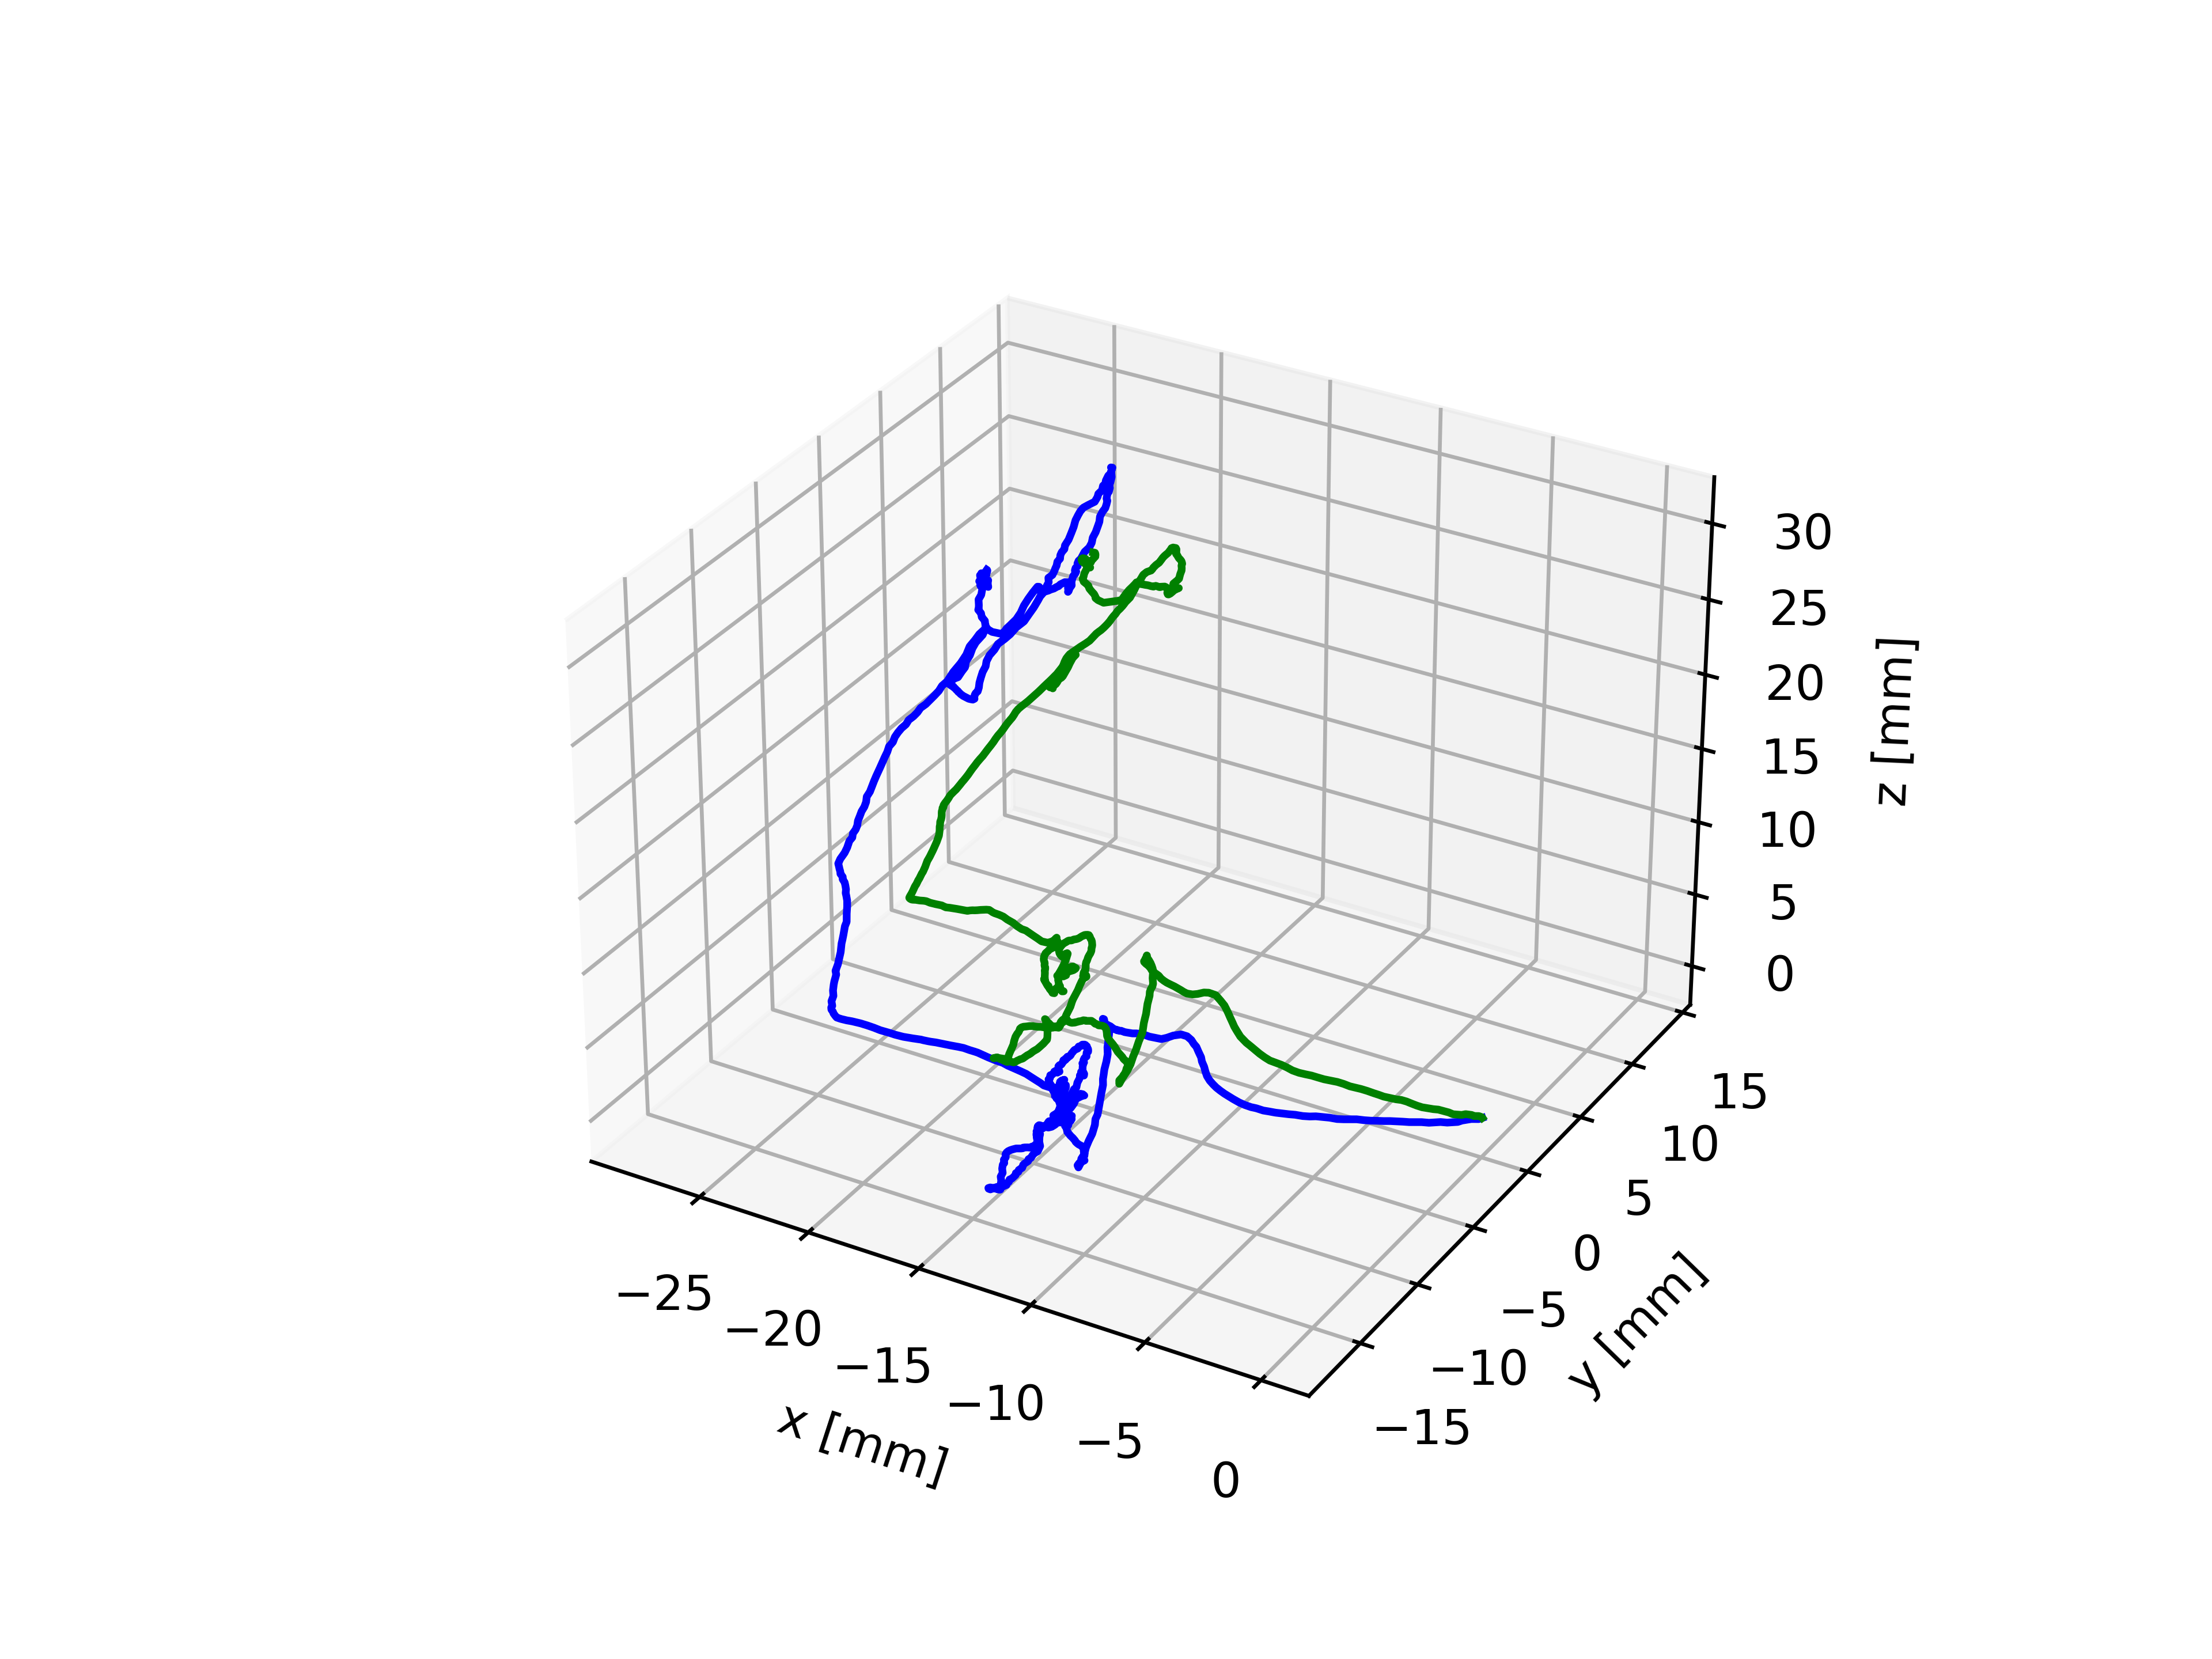

In [29]:
!python {script_folder}/export_gt_pose.py --split endovis --data_path /content/
!python {script_folder}/evaluate_pose.py --data_path frames/{video_name} --eval_split endovis --load_weights_folder Model_trained_end_to_end
!python {script_folder}/visualize_pose.py
from google.colab import files
files.download('vo.png')

from PIL import Image
a = Image.open('vo.png')
a.show()

# LiteMono

In [30]:
script_folder = "Lite-Mono"  # "AF-SfMLearner" #"Lite-Mono"

!mkdir Lite-Mono/splits/endovis/
!cp AF-SfMLearner/evaluate_pose.py {script_folder}/evaluate_pose.py
!cp AF-SfMLearner/export_gt_pose.py {script_folder}/export_gt_pose.py
!cp AF-SfMLearner/visualize_pose.py {script_folder}/visualize_pose.py
!cp AF-SfMLearner/networks/pose_decoder.py {script_folder}/networks/pose_decoder.py
!cp AF-SfMLearner/networks/resnet_encoder.py {script_folder}/networks/resnet_encoder.py
!cp AF-SfMLearner/splits/endovis/test_files_sequence2.txt {script_folder}/splits/endovis/

!cp -r MonoDepth/datasets/ {script_folder}/

modify_py(script_folder)

Exporting ground truth depths for endovis
Saving to endovis
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
-> Computing pose predictions

   Trajectory error: 0.1034, std: 0.0613


   Rotation error: 0.0071, std: 0.0020

Figure(640x480)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

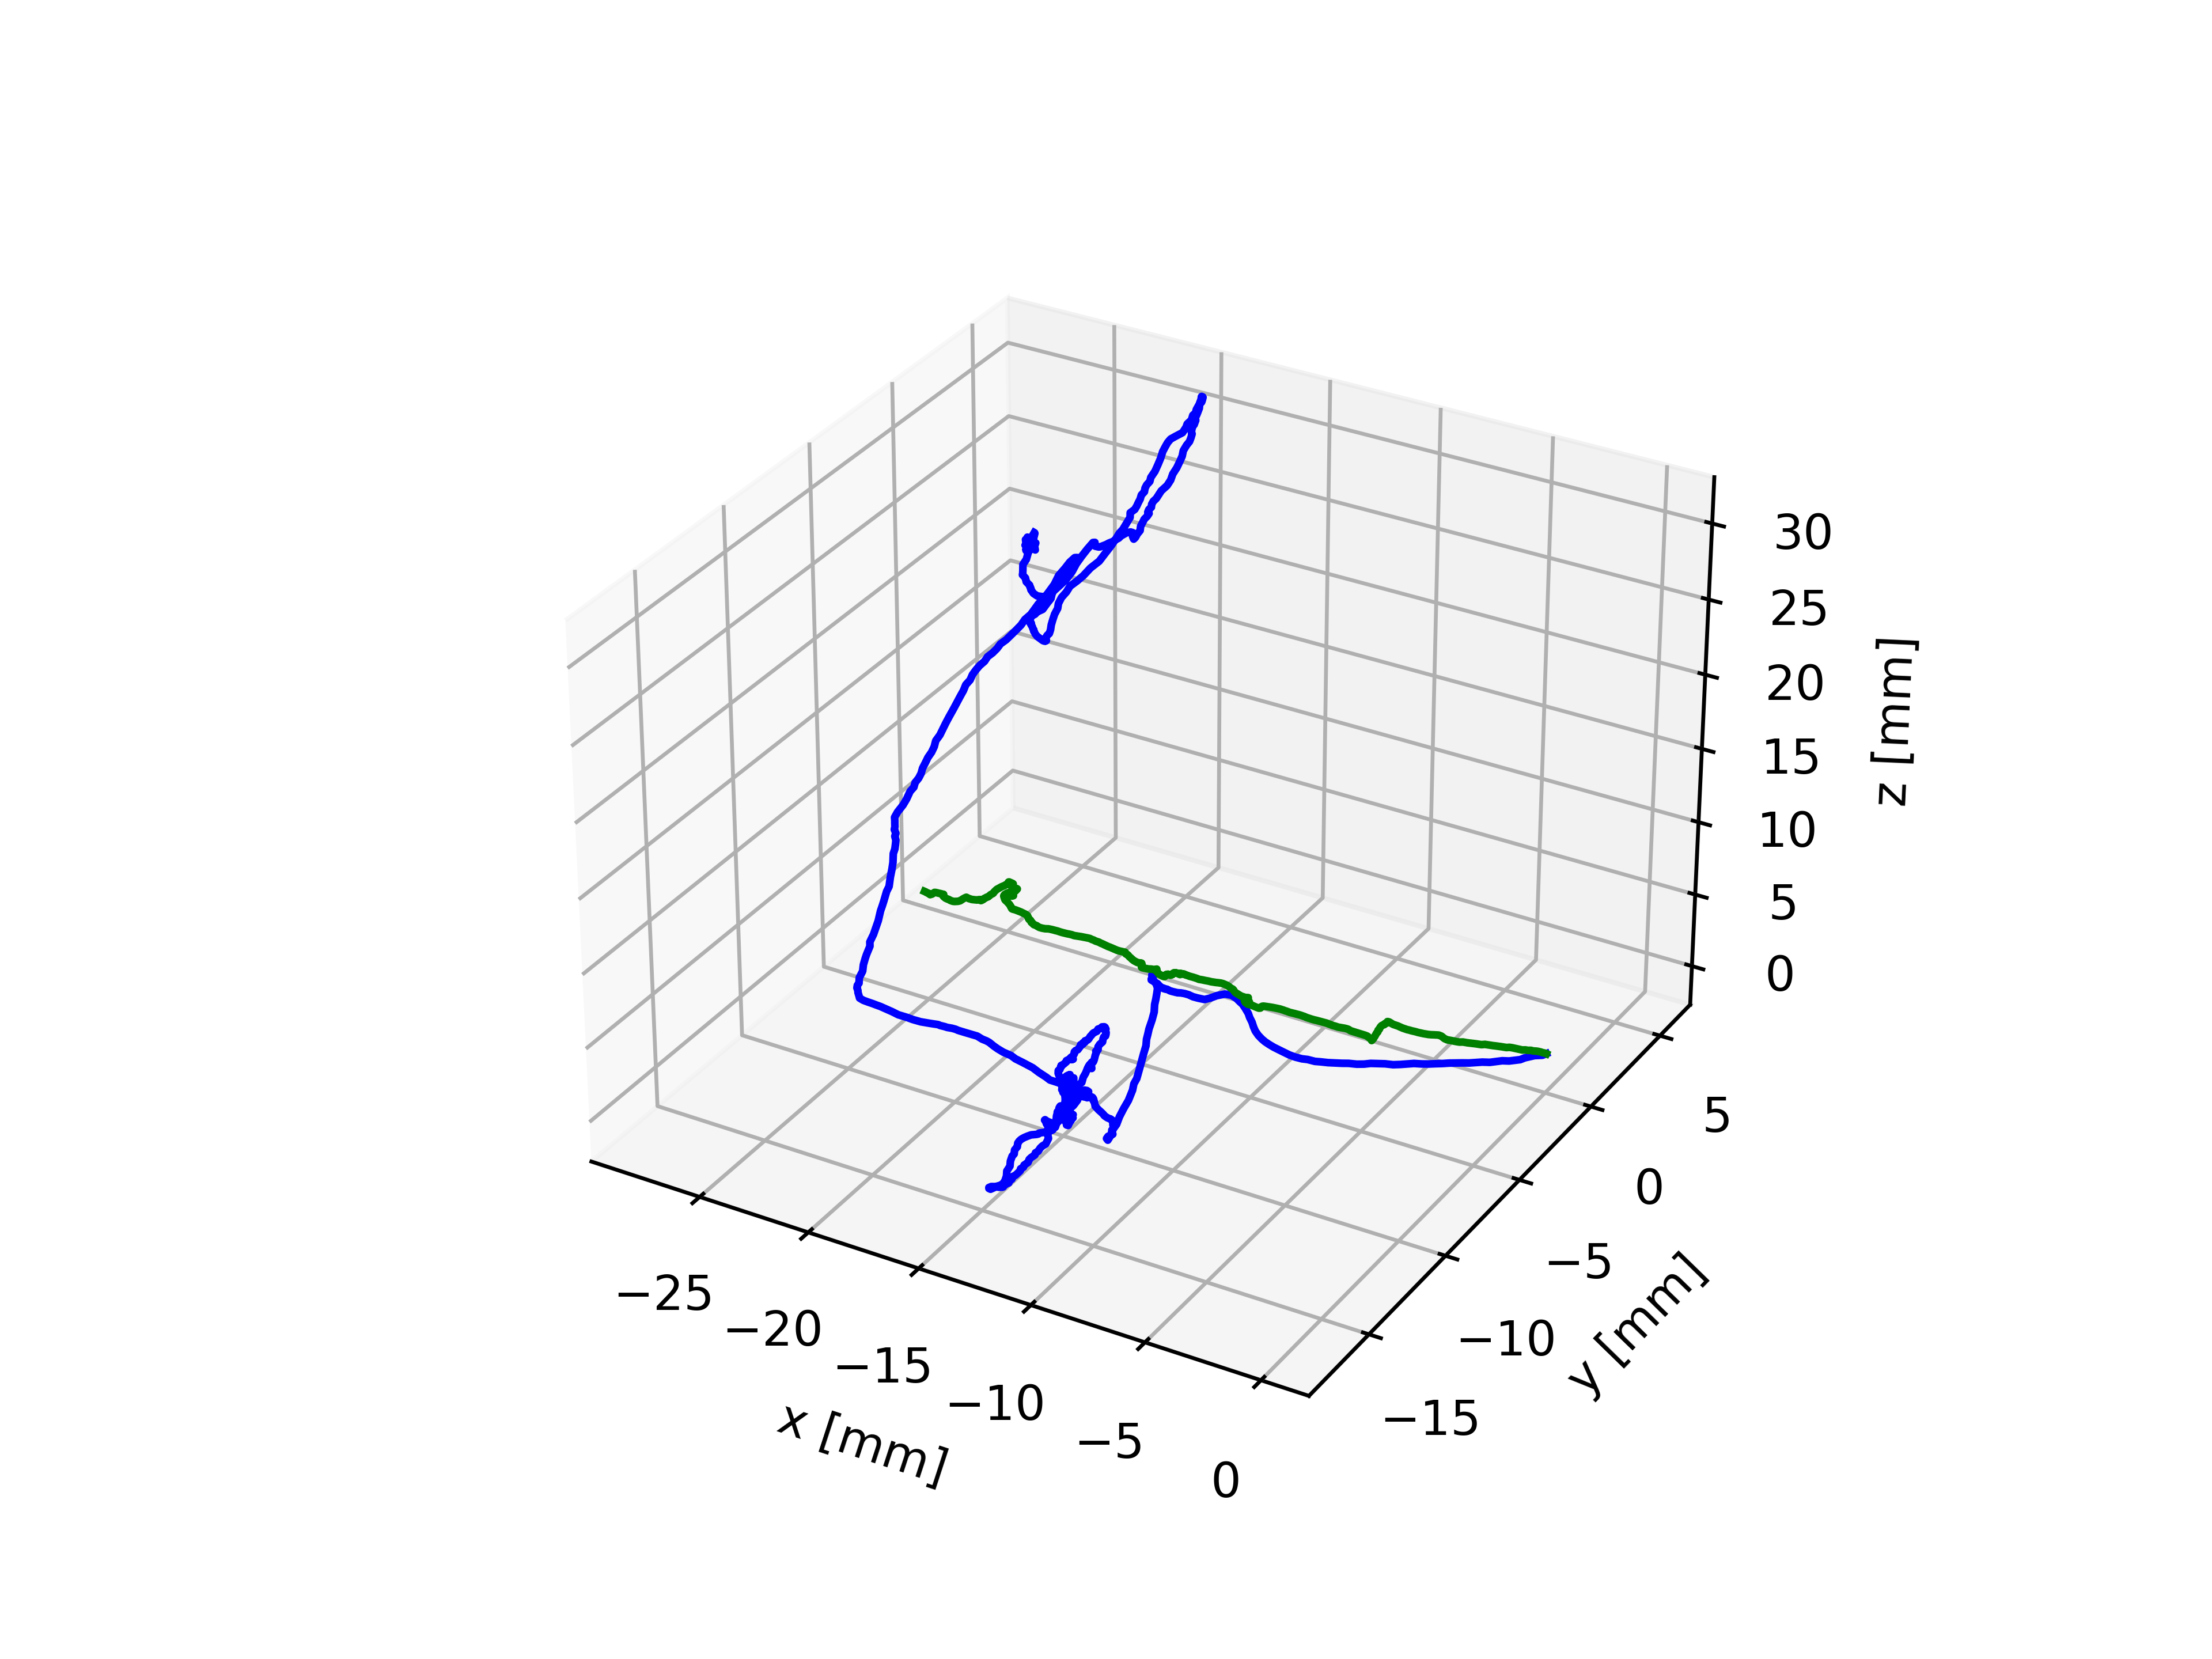

In [31]:
!python {script_folder}/export_gt_pose.py --split endovis --data_path /content/
!python {script_folder}/evaluate_pose.py --data_path frames/{video_name} --eval_split endovis --load_weights_folder weights_162
!python {script_folder}/visualize_pose.py
from google.colab import files
files.download('vo.png')

from PIL import Image
a = Image.open('vo.png')
a.show()

# monodepth2

In [26]:
script_folder = "MonoDepth"  # "AF-SfMLearner" #"Lite-Mono"

!cp AF-SfMLearner/evaluate_pose.py {script_folder}/evaluate_pose.py
!cp AF-SfMLearner/export_gt_pose.py {script_folder}/export_gt_pose.py
!cp AF-SfMLearner/visualize_pose.py {script_folder}/visualize_pose.py
!cp AF-SfMLearner/networks/pose_decoder.py {script_folder}/networks/pose_decoder.py
!cp AF-SfMLearner/networks/resnet_encoder.py {script_folder}/networks/resnet_encoder.py
!cp AF-SfMLearner/splits/endovis/test_files_sequence2.txt {script_folder}/splits/endovis/

modify_py(script_folder)

Exporting ground truth depths for endovis
Saving to endovis
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
-> Computing pose predictions

   Trajectory error: 0.1269, std: 0.0781


   Rotation error: 0.0074, std: 0.0020

Figure(640x480)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

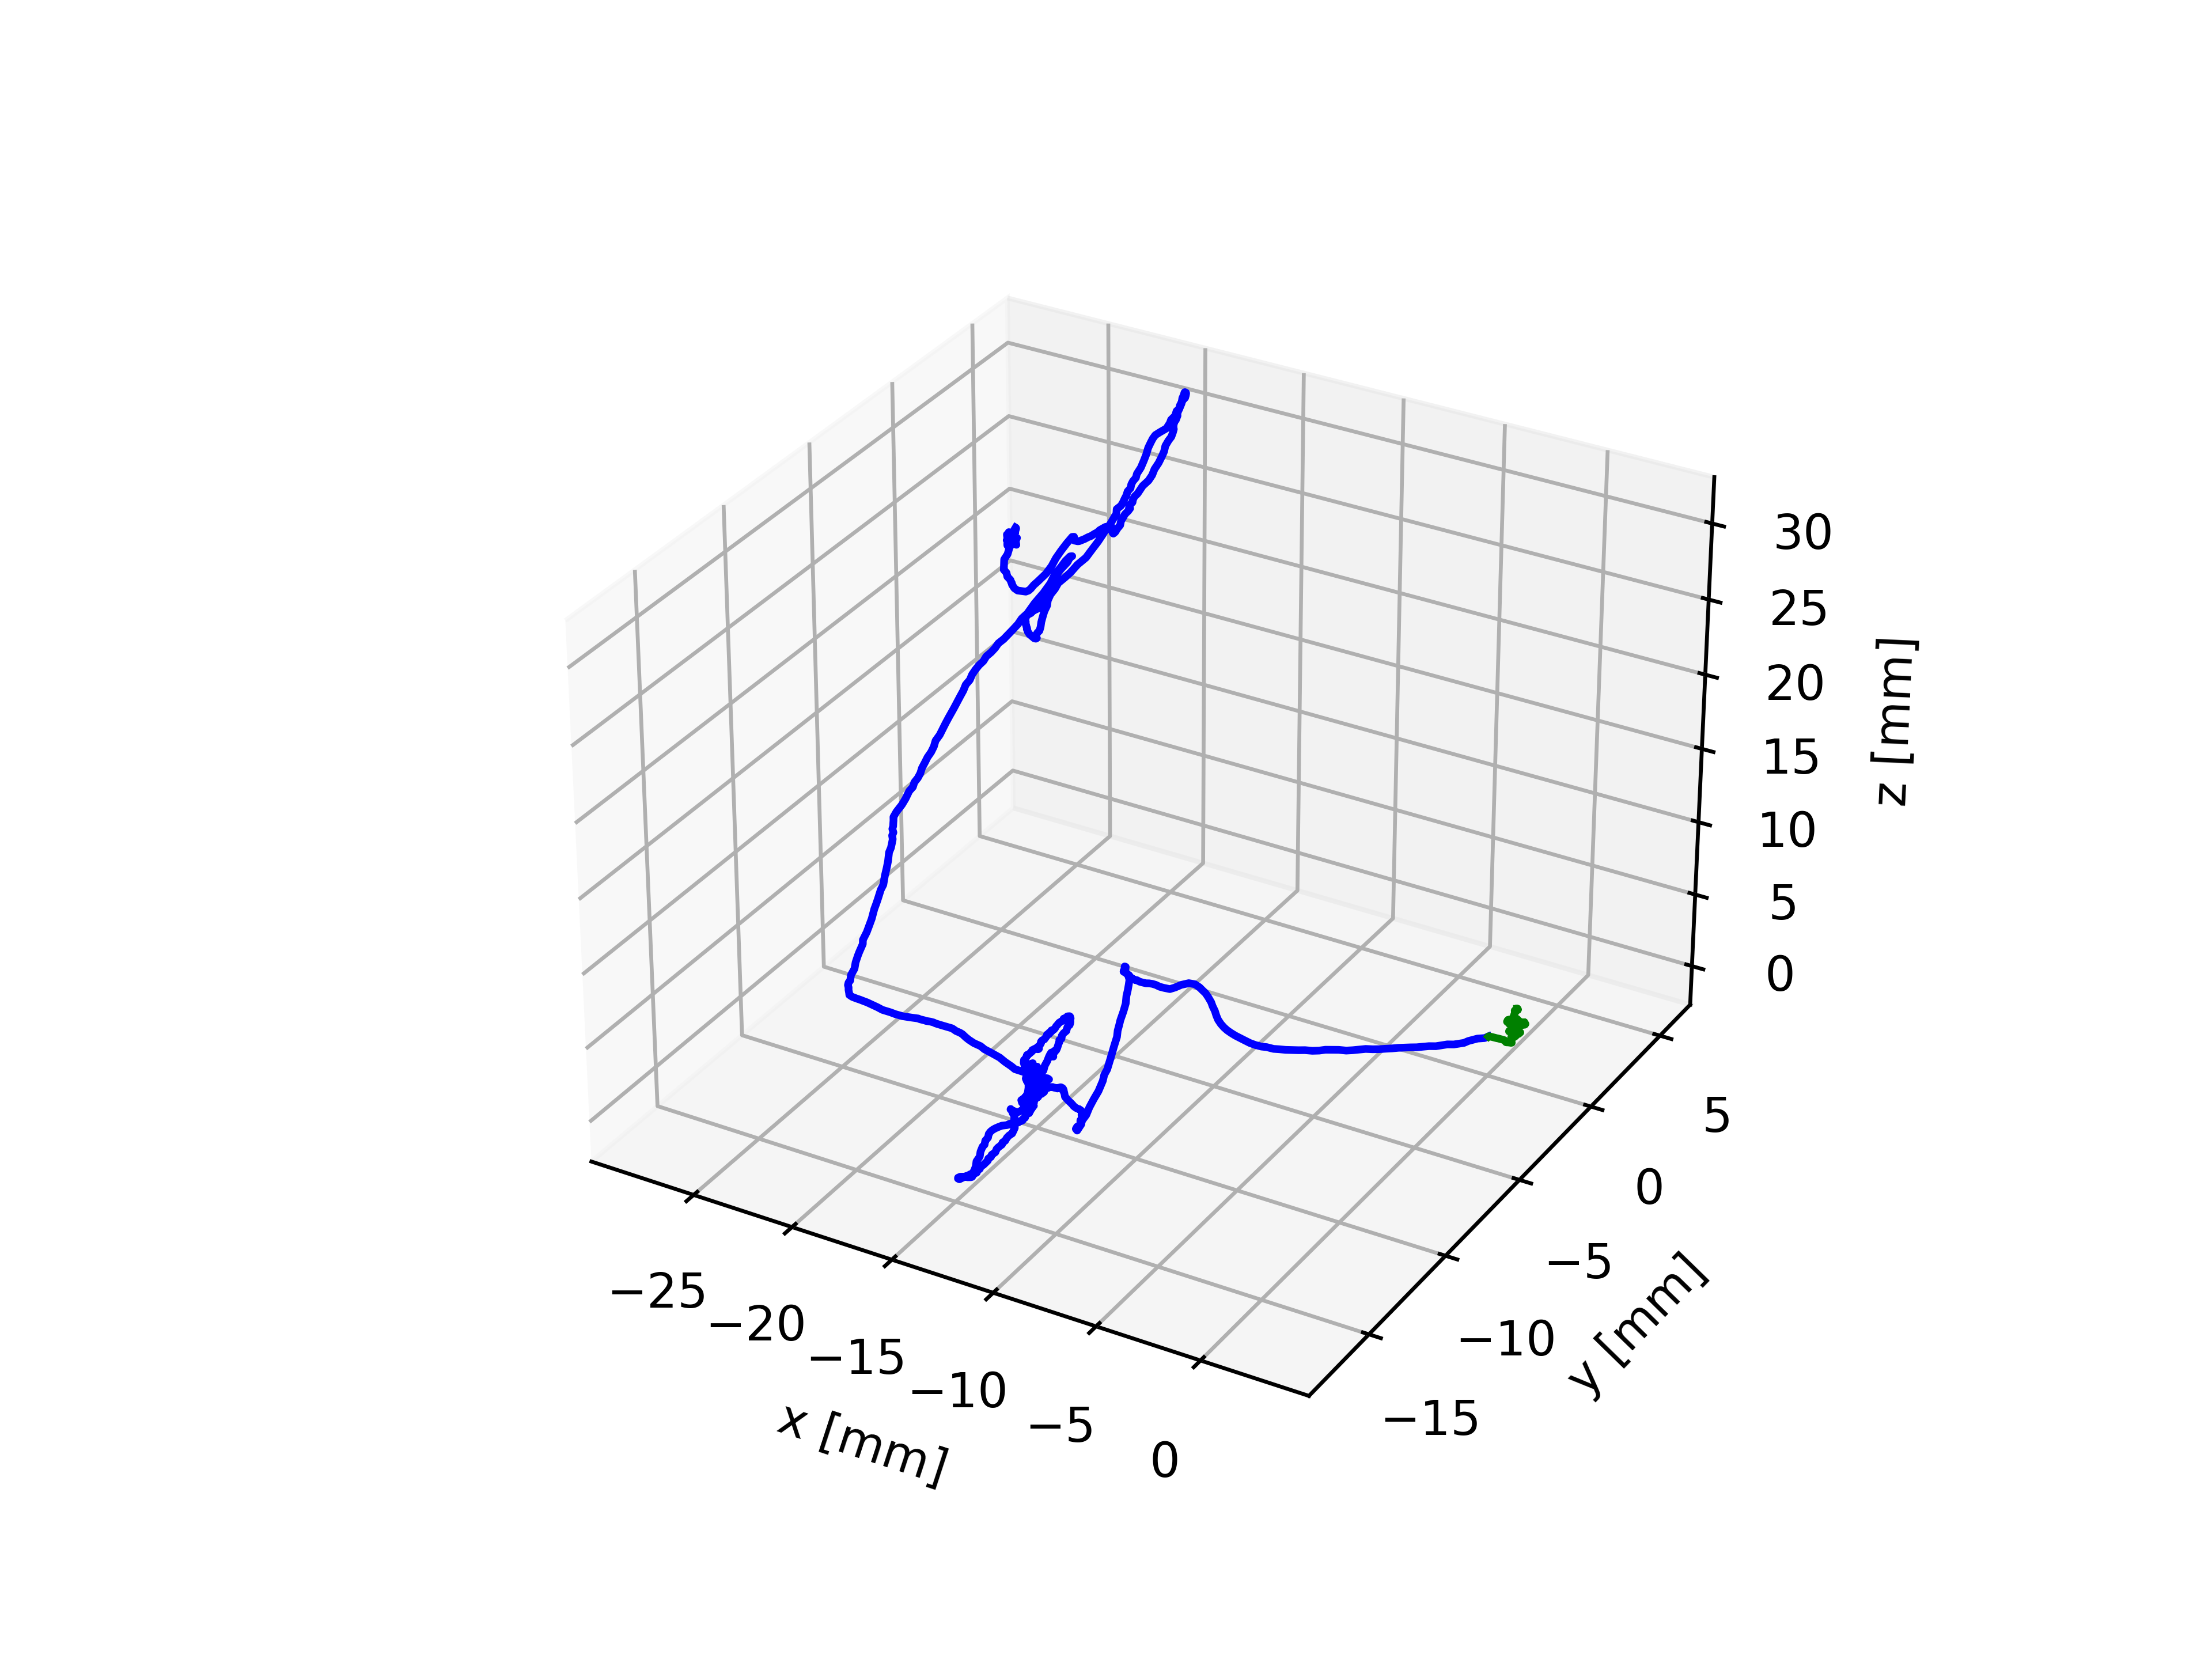

In [27]:
!python {script_folder}/export_gt_pose.py --split endovis --data_path /content/
!python {script_folder}/evaluate_pose.py --data_path frames/{video_name} --eval_split endovis --load_weights_folder weights_147
!python {script_folder}/visualize_pose.py

from google.colab import files
files.download('vo.png')

from PIL import Image
a = Image.open('vo.png')
a.show()